In [9]:
import torch 
import train_script as ts
import matplotlib.pyplot as plt
from fmfts.experiments.rti3d_full.models import VelocityModelFullRTI3D
from fmfts.dataloader.rti3d_full import DatasetFullRTI3D

torch.set_grad_enabled(False)
torch.set_default_device("cuda")

velocity = VelocityModelFullRTI3D(features = ts.features)
velocity.load_state_dict(torch.load("trained_models/_model_velocity.pt", weights_only=True))
dataset_test = DatasetFullRTI3D(ts.At, mode="test", dt=ts.dt, dx=ts.dx, dy=ts.dy, dz=ts.dz, include_timestamp=ts.include_timestamp)

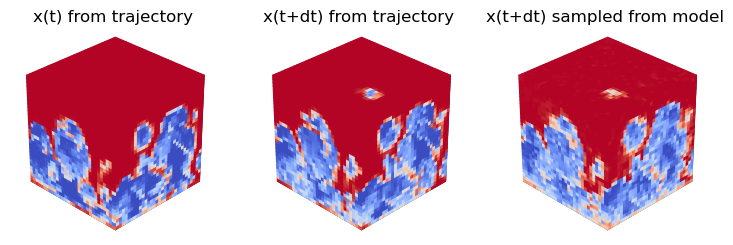

In [10]:
# demonstrates how one can predict a single sample
y, x = dataset_test.get(1, 90, sequence_len=2)
x_pred = velocity.sample(y[None], steps=10, method="midpoint")

# plotting
fig, ax = plt.subplots(1, 3, figsize=(3*3, 3), subplot_kw=dict(projection="3d"))
dataset_test.plot(y, ax[0])
dataset_test.plot(x, ax[1])
dataset_test.plot(x_pred, ax[2])
ax[0].set_title("x(t) from trajectory")
ax[1].set_title("x(t+dt) from trajectory")
ax[2].set_title("x(t+dt) sampled from model")
for i in range(3): 
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_zticks([])
plt.show()

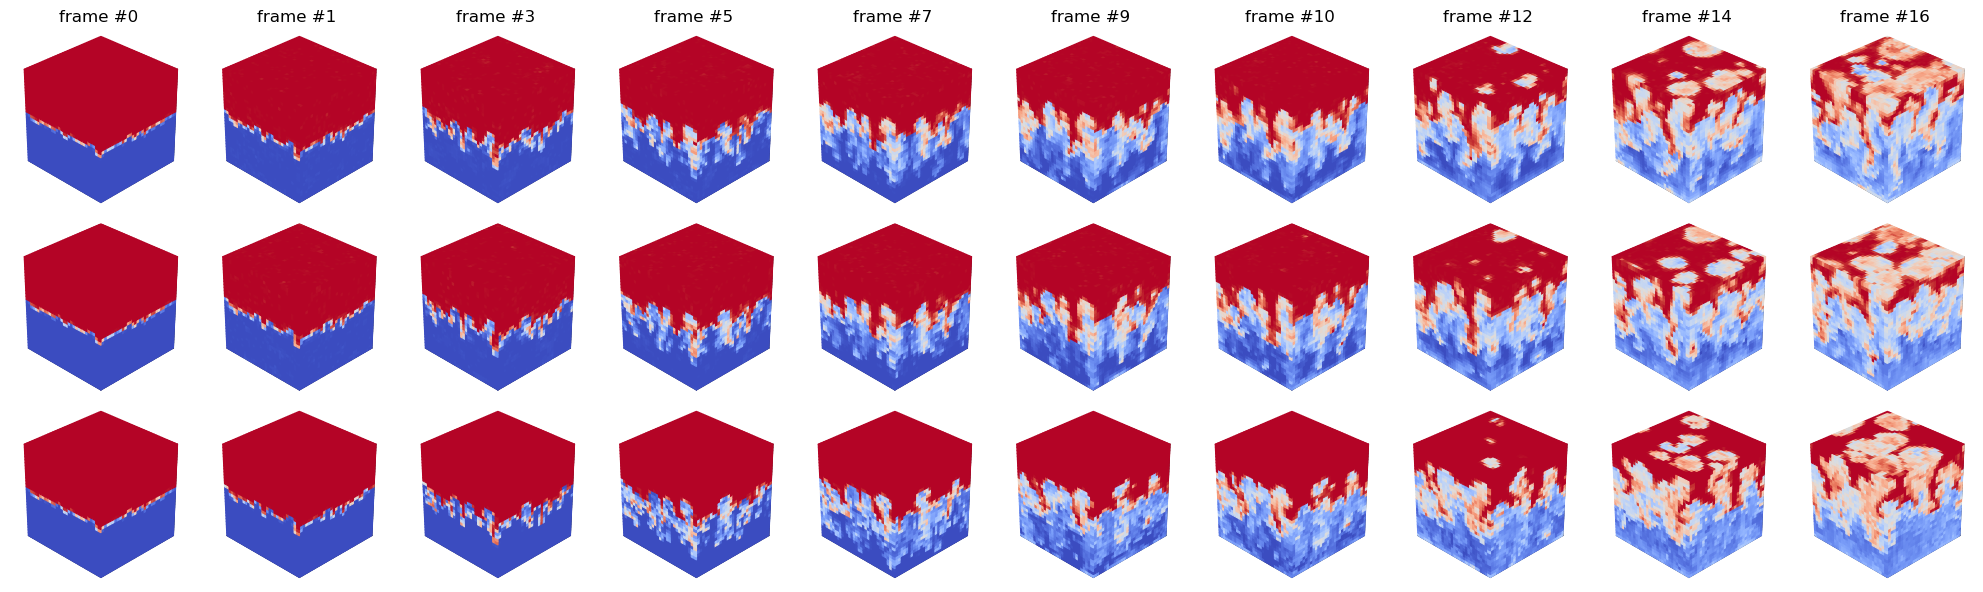

In [11]:
# demonstrates how one can generate multiple trajectories
n_trajectories = 2
n_predictions = 18
y = dataset_test.get(0, 30, sequence_len=n_predictions)

xs = torch.empty(n_predictions, n_trajectories, *y.shape[1:])
xs[0,:] = y[0].clone()
for k in range(n_predictions-1):
    xs[k+1] = velocity.sample(xs[k], steps=5, method="euler") 

# plotting
n_plots   = 10

fig, ax = plt.subplots(n_trajectories + 1, n_plots, figsize=(n_plots*2, (n_trajectories+1)*2), subplot_kw=dict(projection="3d"))
for k in range(n_trajectories):
    for i in range(n_plots):
        l = i * n_predictions // n_plots
        dataset_test.plot(xs[l, k], ax[k, i])
        ax[k, i].set_xticks([])
        ax[k, i].set_yticks([])
        ax[k, i].set_zticks([])
    ax[k,0].set_zlabel(f"sampled trajectory #{k+1}")

for i in range(n_plots):
    l = i * n_predictions // n_plots
    if l < len(y): 
        dataset_test.plot(y[l], ax[-1, i])
        ax[-1, i].set_xticks([])
        ax[-1, i].set_yticks([])
        ax[-1, i].set_zticks([])
    else:                          
        ax[-1, i].remove()

    ax[0, i].set_title(f"frame #{l}")
# ax[-1, 0].set_zlabel("true trajectory")

plt.tight_layout()
plt.show()